## TEMAN BAGAYA 👕

# ⚙️ Libraries

In [6]:
# Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Base Path for all files
base_dir = '/content/drive/MyDrive/TemanBagaya/Train/'

# ⚙️ Load Images For Training & Testing


In [14]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 2240 images belonging to 12 classes.
Found 244 images belonging to 12 classes.


# ⚙️ Initialize InceptionV3 Pretrained Model


In [16]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('/content/drive/MyDrive/TemanBagaya/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

# ⚙️ Add Custom Layer


In [17]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(12, activation='softmax') # 12 Output Neurons for 12 Classes
])

In [18]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# ⚙️ View Model Summary & Plot


In [19]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 12)                12300     
                                                                 
Total params: 23,913,260
Trainable params: 2,110,476
Non-trainable params: 21,802,784
____________________________________

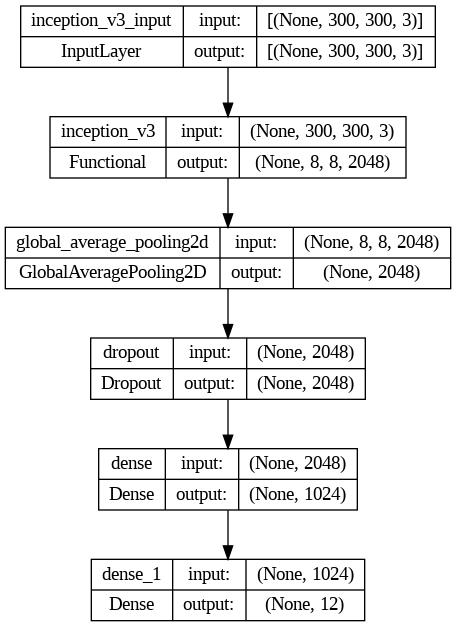

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# ⚙️ Model Building


In [21]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [22]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 70
validation_steps : 7


# ⚙️ Model Training


In [23]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"
 
# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 1.2760 - accuracy: 0.5969 
Epoch 1: val_accuracy improved from -inf to 0.74107, saving model to ./model_01-0.74.h5
70/70 [==============================] - 1934s 27s/step - loss: 1.2760 - accuracy: 0.5969 - val_loss: 0.8150 - val_accuracy: 0.7411
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.8214
Epoch 2: val_accuracy improved from 0.74107 to 0.85714, saving model to ./model_02-0.86.h5
70/70 [==============================] - 96s 1s/step - loss: 0.5573 - accuracy: 0.8214 - val_loss: 0.5357 - val_accuracy: 0.8571
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8839
Epoch 3: val_accuracy improved from 0.85714 to 0.86607, saving model to ./model_03-0.87.h5
70/70 [==============================] - 99s 1s/step - loss: 0.4081 - accuracy: 0.8839 - val_loss: 0.4175 - val_accuracy: 0.8661
Epoch 4/10
70/70 [==============================] - ETA: 

### Model still improving, train for more epochs for better results !!!

# ⚙️ Model Evaluation


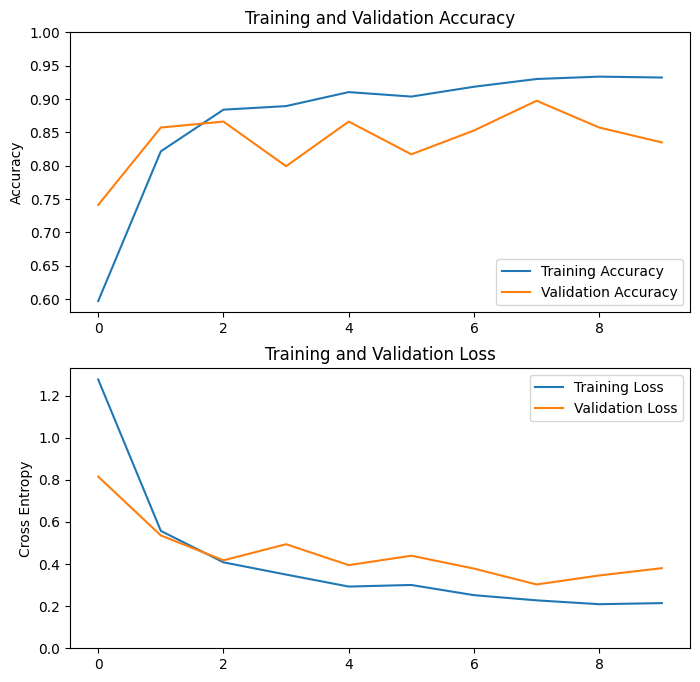

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

8/8 [==============================] - 6s 794ms/step - loss: 0.3810 - accuracy: 0.8402
test accuracy :  0.8401639461517334


In [34]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("/content/drive/MyDrive/TemanBagaya/model_08-0.90.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Celana Jeans', 1: 'Celana Jogger ', 2: 'Celana Kargo', 3: 'Celana Trouser',
              4: 'Crewneck', 5: 'Kaos Oversized', 6: 'Kaos Stripe', 7: 'Kemeja Flannel',
              8: 'Sandal Trial', 9: 'Sepatu Athletics', 10: 'Sepatu Canvas', 11: 'Sepatu High-top Basketball'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

# ⚙️ Model Testing With Graphs


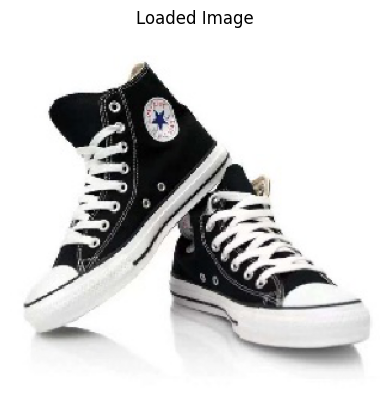

1/1 [==============================] - 1s 1s/step


Maximum Probability:  0.95003104
Classified: Sepatu Canvas 



-------------------Individual Probability--------------------------------

CELANA JEANS : 0.01 %
CELANA JOGGER  : 0.01 %
CELANA KARGO : 0.01 %
CELANA TROUSER : 0.0 %
CREWNECK : 0.0 %
KAOS OVERSIZED : 0.0 %
KAOS STRIPE : 0.0 %
KEMEJA FLANNEL : 0.0 %
SANDAL TRIAL : 0.07 %
SEPATU ATHLETICS : 2.75 %
SEPATU CANVAS : 95.0 %
SEPATU HIGH-TOP BASKETBALL : 2.14 %


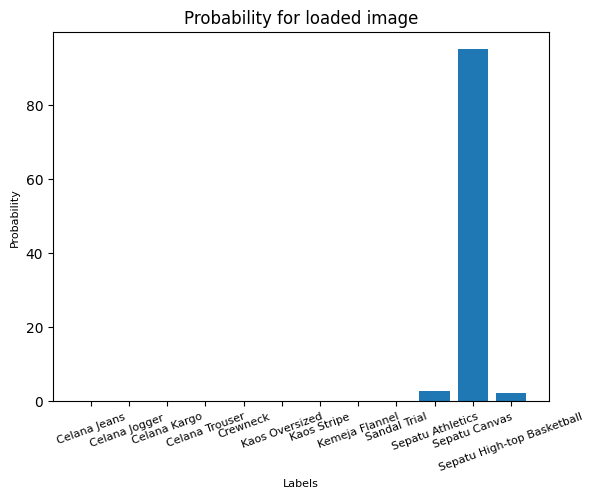

In [35]:
predict("/content/drive/MyDrive/TemanBagaya/Train/Sepatu Canvas/225.jpg")

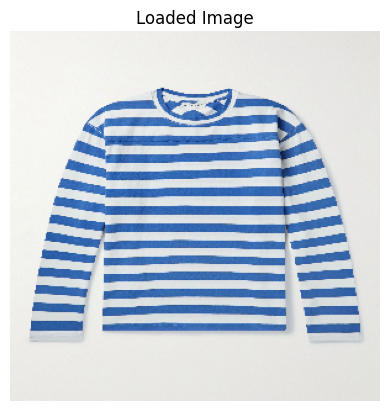

1/1 [==============================] - 0s 57ms/step


Maximum Probability:  0.8830422
Classified: Kaos Stripe 



-------------------Individual Probability--------------------------------

CELANA JEANS : 0.02 %
CELANA JOGGER  : 0.15 %
CELANA KARGO : 0.01 %
CELANA TROUSER : 0.1 %
CREWNECK : 4.68 %
KAOS OVERSIZED : 0.55 %
KAOS STRIPE : 88.3 %
KEMEJA FLANNEL : 6.17 %
SANDAL TRIAL : 0.01 %
SEPATU ATHLETICS : 0.01 %
SEPATU CANVAS : 0.01 %
SEPATU HIGH-TOP BASKETBALL : 0.0 %


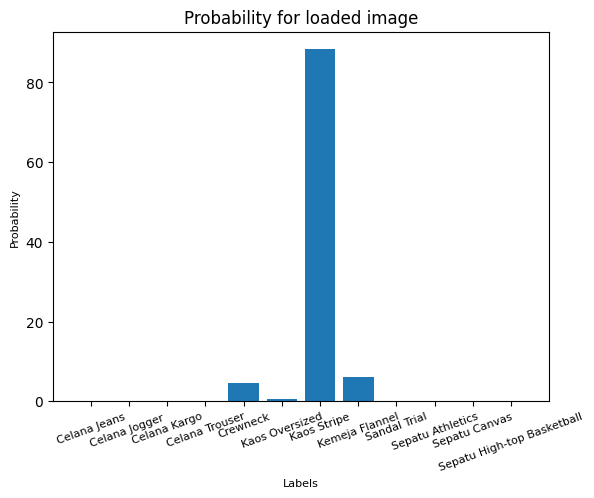

In [31]:
predict("/content/drive/MyDrive/TemanBagaya/Train/Kaos Stripe/1113.jpg")

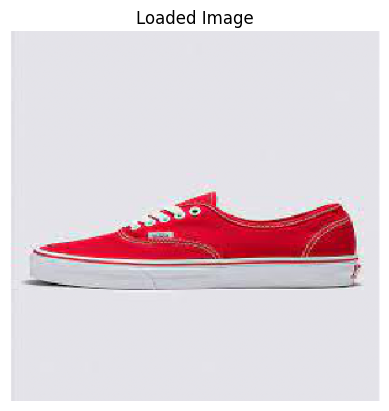

1/1 [==============================] - 0s 27ms/step


Maximum Probability:  0.902871
Classified: Sepatu Canvas 



-------------------Individual Probability--------------------------------

CELANA JEANS : 0.0 %
CELANA JOGGER  : 0.02 %
CELANA KARGO : 0.01 %
CELANA TROUSER : 0.0 %
CREWNECK : 0.0 %
KAOS OVERSIZED : 0.02 %
KAOS STRIPE : 0.0 %
KEMEJA FLANNEL : 0.0 %
SANDAL TRIAL : 0.07 %
SEPATU ATHLETICS : 7.6 %
SEPATU CANVAS : 90.29 %
SEPATU HIGH-TOP BASKETBALL : 1.99 %


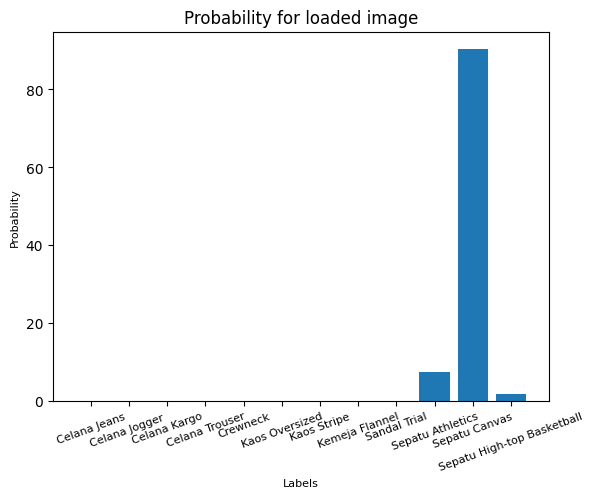

In [33]:
predict("/content/drive/MyDrive/TemanBagaya/Pengujian/slipon2.jpg")

# LifeatBangkit
